# Random Matrices, Covariance Estimation and Brownian Motion

In [52]:
using LinearAlgebra
using Statistics
using Plots
using Random
using Distributions
using CovarianceEstimation
using StatsBase
import Base: angle

### Two Ensembles

We'll generate some large random matrices from two famous ensembles:

- **GOE (Gaussian Orthogonal Ensemble)**: Real, symmetric matrices.
- **GUE (Gaussian Unitary Ensemble)**: Complex, Hermitian matrices.

1. **GOE (Real Symmetric)**  
   - Off-diagonal entries are normal random variables with variance \(1/n\).  
   - Diagonal entries have variance \(2/n\).  
   - Ensures a real symmetric matrix whose eigenvalues lie near \([-2,2]\).

2. **GUE (Complex Hermitian)**  
   - Off-diagonal entries are complex with real and imaginary parts each having variance \(1/(2n)\).  
   - Diagonal entries are purely real with variance \(1/n\).  
   - Ensures a Hermitian matrix whose eigenvalues also lie near \([-2,2]\).

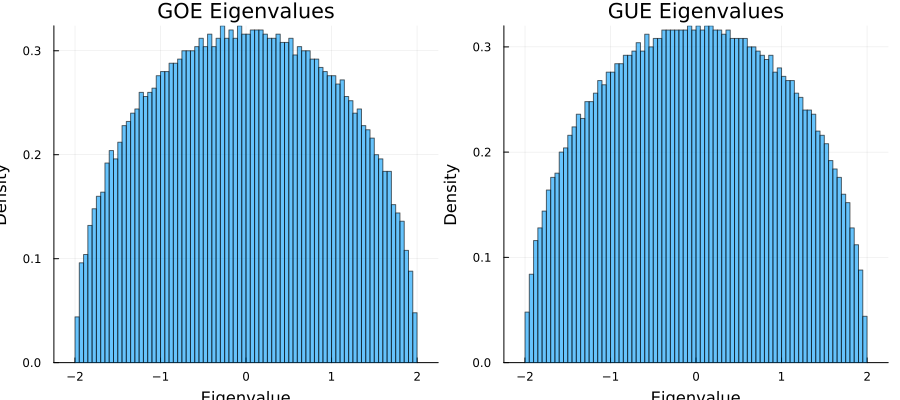

In [62]:
function generate_goe(n::Int)
    M = zeros(Float64, n, n)
    # Fill off-diagonals (i < j)
    for i in 1:n
        for j in i+1:n
            val = randn() / sqrt(n)      # variance = 1/n
            M[i, j] = val
            M[j, i] = val
        end
    end
    # Fill diagonals
    for i in 1:n
        M[i, i] = sqrt(2) * randn() / sqrt(n)  # variance = 2/n
    end
    return M
end


function generate_gue(n::Int)
    A = randn(n, n) + im * randn(n, n)
    # (A + A') / 2 makes it Hermitian; dividing by sqrt n fixes the total variance
    return (A + A') ./ (2 * sqrt(n))
end

n = 5000

goe = generate_goe(n)
gue = generate_gue(n)

eigs_goe = eigvals(goe)
eigs_gue = eigvals(gue)

p1 = histogram(eigs_goe, bins=100, normalize=:pdf, 
    title="GOE Eigenvalues", alpha=0.6,
    label="", xlabel="Eigenvalue", ylabel="Density")

p2 = histogram(eigs_gue, bins=100, normalize=:pdf, 
    title="GUE Eigenvalues", alpha=0.6,
    label="", xlabel="Eigenvalue", ylabel="Density")

plot(p1, p2, layout=(1, 2), size=(900, 400))

### Wigner Semicircle Law

Observe they follow the **Wigner semicircle distribution**. For certain large random matrices, when you look at the histogram of their eigenvalues (when scaled), the distribution converges to a **semicircle** given by the formula:

$$
\rho(x) =
\begin{cases}
  \displaystyle \frac{\sqrt{4 - x^2}}{2\pi}, & \text{if } |x|\le 2,\\[1em]
  0, & \text{otherwise}.
\end{cases}
$$

In other words, most of the eigenvalues lie between \(-2\) and \(+2\), and when plotted as a histogram, they form a shape that exactly matches a semicircle of radius 2. This is quite interesting as from these very random matrices we can create a somewhat deterministic pattern of eigenvalues when $n$ is large.

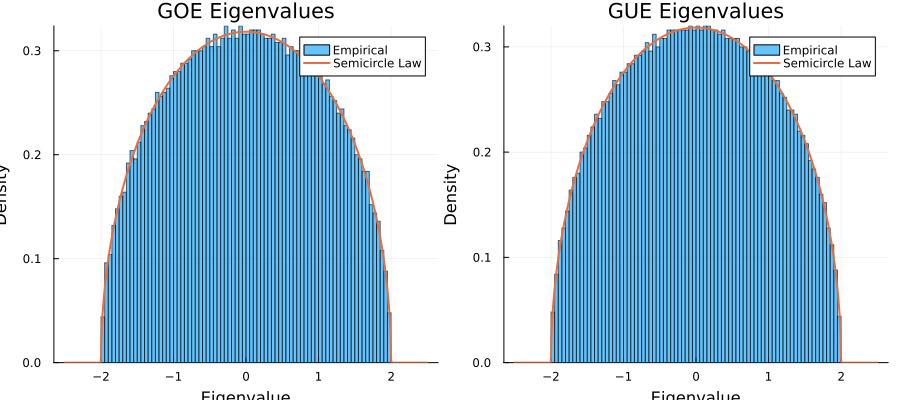

In [64]:
semicirclelaw(x) = abs(x) ≤ 2 ? sqrt(4 - x^2) / (2π) : 0.0

x_vals = range(-2.5, 2.5, length=1000)
y_vals = [semicirclelaw(x) for x in x_vals]

p1 = histogram(eigs_goe, bins=100, normalize=:pdf, alpha=0.6,
    xlabel="Eigenvalue", ylabel="Density", title="GOE Eigenvalues",
    label="Empirical")
plot!(p1, x_vals, y_vals, lw=2, label="Semicircle Law", legend=:topright)

p2 = histogram(eigs_gue, bins=100, normalize=:pdf, alpha=0.6,
    xlabel="Eigenvalue", ylabel="Density", title="GUE Eigenvalues",
    label="Empirical")
plot!(p2, x_vals, y_vals, lw=2, label="Semicircle Law", legend=:topright)

plot(p1, p2, layout=(1, 2), size=(900, 400))

### Tracy-Widom Law

Let's look at the largest Eigenvalue: while in the previous cell we saw that almost all of the eigenvalues follow the semicircle law. If we just look at the behavior of the largest eigenvalue for large random matrices, this eigenvalue tends to be very close to \(2\) and fluctuates around this.

To study these fluctuations, we apply a special scaling:
  
$$
  X_n = (\lambda_{\text{max}} - 2) \, n^{2/3}
$$
  
  Here:
  - $\lambda_{\text{max}}$ is the largest eigenvalue of the matrix.
  - $n$ is the matrix size.
  - The factor $n^{2/3}$ is chosen because the fluctuations around $2$ decrease roughly as $n^{-2/3}$ when the matrix becomes larger.

The Tracy–Widom law helps us understand extreme fluctuations in complex systems proxied through large random matrices.


Mean of scaled largest eigenvalues: -1.3501651786927302
Standard deviation: 1.295224114461802
Min: -4.443035922610901, Max: 3.365497238523831


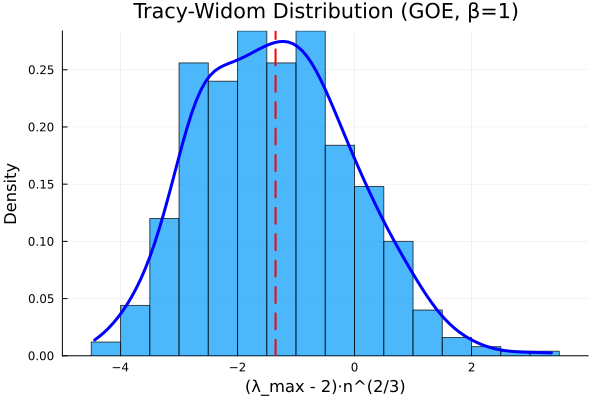

In [131]:
num_samples = 500
largest_eigs = zeros(num_samples)

for i in 1:num_samples
    mat = generate_goe(n)
    largest_eigs[i] = maximum(eigvals(mat))
end

scaled_largest = (largest_eigs .- 2) .* n^(2/3)

histogram(scaled_largest, bins=30, normalize=:pdf,
          title="Tracy-Widom Distribution (GOE, β=1)",
          xlabel="(λ_max - 2)·n^(2/3)", ylabel="Density",
          legend=false, alpha=0.7)

mean_val = mean(scaled_largest)
std_val = std(scaled_largest)
vline!([mean_val], linestyle=:dash, linewidth=2, color=:red)

println("Mean of scaled largest eigenvalues: $mean_val")
println("Standard deviation: $std_val")
println("Min: $(minimum(scaled_largest)), Max: $(maximum(scaled_largest))")

x_range = range(minimum(scaled_largest), maximum(scaled_largest), length=100)
density_curve = zeros(length(x_range))
bandwidth = 0.3 * std_val

for i in 1:length(x_range)
    for val in scaled_largest
        density_curve[i] += exp(-(x_range[i] - val)^2 / (2 * bandwidth^2))
    end
end
density_curve = density_curve ./ (sum(density_curve) * (x_range[2] - x_range[1]))

plot!(x_range, density_curve, linewidth=3, color=:blue)

In [133]:
mean_unscaled = mean_val/(n^(2/3)) + 2

1.900518979066571

### Sample Covariance Matrices

- **Data Matrix $X$:**  
  Imagine you have $n$ samples (rows) of $p$ variables (columns). We can represent these data in an $n \times p$ matrix $X$, where each entry is drawn from a standard normal distribution.

- **Sample Covariance Matrix $S$:**  
  The sample covariance matrix is computed as  
  $$
  S = \frac{X^T X}{n},
  $$
  which is a $p \times p$ matrix.

### The Marchenko–Pastur Law

When the dimensions $n$ (number of samples) and $p$ (number of variables) are both large and their ratio  
$$
c = \frac{p}{n}
$$
remains fixed, the eigenvalues of $S$ follow a predictable pattern described by the MP law. This law gives the probability density of eigenvalues $\lambda$ as

$$
\rho_{\text{MP}}(\lambda) = \frac{1}{2\pi c \lambda} \sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)},
$$
for $\lambda$ in the interval $[\lambda_-, \lambda_+]$, where

$$
\lambda_- = (1 - \sqrt{c})^2, \quad \lambda_+ = (1 + \sqrt{c})^2.
$$

Outside this interval, the density is zero.

Here again we see some RMT magic: even though the data is completely random, the eigenvalue distribution of its covariance matrix follows a very specific and predictable law—the Marchenko–Pastur law.


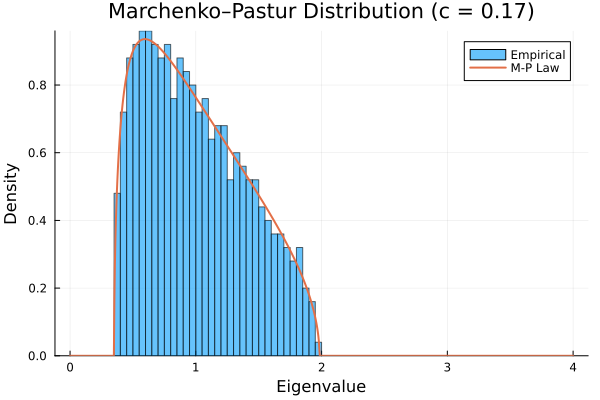

In [78]:
n = 3000
p = 500
c = p / n

X = randn(n, p)
S = (X' * X) / n
eigs_mp = eigvals(S)  

histogram(eigs_mp, bins=50, normalize=:pdf,
          label="Empirical", alpha=0.6,
          xlabel="Eigenvalue", ylabel="Density")

function mp_density(x, c)
    λ_minus = (1 - sqrt(c))^2
    λ_plus = (1 + sqrt(c))^2
    if x < λ_minus || x > λ_plus
        return 0.0
    else
        return sqrt((λ_plus - x) * (x - λ_minus)) / (2π * c * x)
    end
end

x_mp = range(0, 4, length=1000)
y_mp = [mp_density(xi, c) for xi in x_mp]

plot!(x_mp, y_mp, label="M-P Law", lw=2,
      title="Marchenko–Pastur Distribution (c = $(round(c, digits=2)))",
      legend=:topright)

### Curses of Dimensionality
In many applications (e.g., finance, genomics, or machine learning), we need to estimate the covariance matrix of a dataset. A naive approach is to *sample covariance matrix*, but when the number of observations is not very large relative to the number of variables, the sample covariance can be noisy and unstable.

### Ledoit-Wolfe Shrinkage
This technique allows us to improves the estimation by “shrinking” the sample covariance matrix toward a more structured target (often a scaled identity matrix). Note like many other shrinkage operators you may know like James Stien, this creates a biased estimator for tradeoff in estimation variance reduction. The resulting estimator is more robust, particularly in high-dimensional settings.


We use the Ledoit–Wolf shrinkage covariance from the `CovarianceEstimation.jl` package.


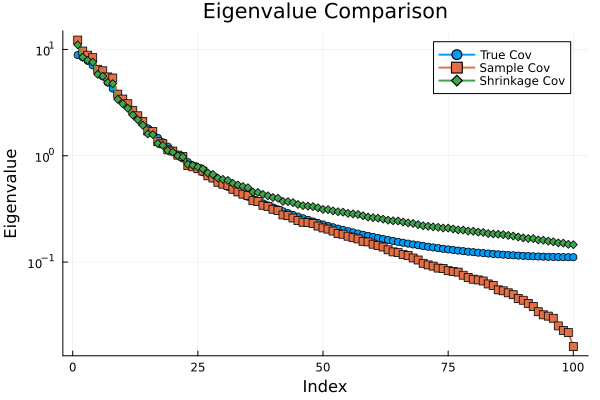

In [107]:
using Random, LinearAlgebra, Statistics, Distributions, CovarianceEstimation, Plots

Random.seed!(123)

n = 200
p = 100

# toeplitz structure
true_cov = [0.8^(abs(i - j)) for i in 1:p, j in 1:p]

dist = MvNormal(zeros(p), true_cov)
X = rand(dist, n)'

sample_cov = cov(X)

S_ledoitwolf = cov(LinearShrinkage(ConstantCorrelation()), X)

mat_true_cov    = Matrix(true_cov)
mat_sample_cov  = Matrix(sample_cov)
mat_shrink_cov  = Matrix(S_ledoitwolf)

p1 = heatmap(mat_true_cov, title="True Covariance", aspect_ratio=1, size=(300,300), colorbar_title="Cov")
p2 = heatmap(mat_sample_cov, title="Sample Covariance", aspect_ratio=1, size=(300,300), colorbar_title="Cov")
p3 = heatmap(mat_shrink_cov, title="Ledoit–Wolf Estimator", aspect_ratio=1, size=(300,300), colorbar_title="Cov")
plot(p1, p2, p3, layout=(1,3), size=(900,300))

eig_true   = sort(eigen(mat_true_cov).values, rev=true)
eig_sample = sort(eigen(mat_sample_cov).values, rev=true)
eig_shrink = sort(eigen(mat_shrink_cov).values, rev=true)

plot(eig_true, label="True Cov", marker=:circle,
     xlabel="Index", ylabel="Eigenvalue",
     title="Eigenvalue Comparison", lw=2,
     yscale=:log10)

plot!(eig_sample, label="Sample Cov", marker=:square, lw=2)
plot!(eig_shrink, label="Shrinkage Cov", marker=:diamond, lw=2)

## Application: High-Dimensional Portfolio

When estimating the covariance matrix of asset returns in a high-dimensional setting (e.g. $ p \gg n $), the sample covariance is super super noisy. This gives us poor portfolio optimization results. One way to improve the estimates is by applying shrinkage (such as the Ledoit–Wolf estimator) which regularizes the covariance estimate.

Consider a minimum variance portfolio allocation problem. From Markowitz's MPT, minimum variance portfolio weights are given by:

$$
w = \frac{\Sigma^{-1} \mathbf{1}}{\mathbf{1}^T \Sigma^{-1} \mathbf{1}},
$$

where $\Sigma$ is the covariance matrix and $\mathbf{1}$ is a vector of ones. We then compute the portfolio risk (i.e. the standard deviation) as

$$
\sigma_p = \sqrt{w^T \Sigma\, w}.
$$

We compare three portfolios:
- **True Minimum Variance:** using the true covariance matrix $\Sigma_{\text{true}}$
- **Sample Covariance Portfolio:** using the sample covariance estimate $S_{\text{sample}}$
- **Ledoit–Wolf Portfolio:** using the shrinkage estimator $S_{\text{lw,cc}}$

We will also compare the “estimated” risk (computed using the estimated covariance) with the “true” risk (computed using \(\Sigma_{\text{true}}\)), and visualize the distribution of portfolio weights.


Estimated vs. True Risk:
Sample Covariance Portfolio:      Estimated risk = 0.0 vs. True risk = 1.45428
Ledoit–Wolf Covariance Portfolio: Estimated risk = 0.05544 vs. True risk = 0.0713
True Minimum Variance Portfolio:  True risk = 0.04401


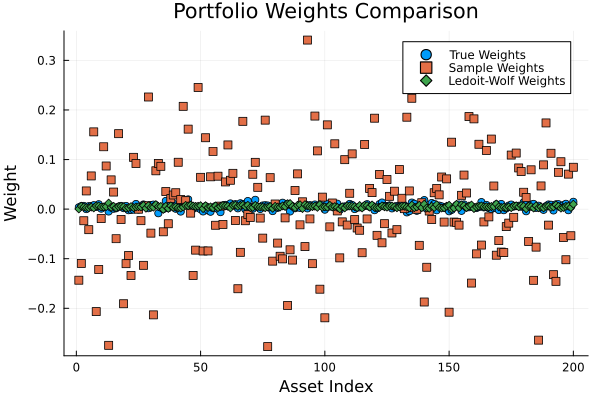

In [128]:
using LinearAlgebra, Statistics, Plots, Random, Distributions

Random.seed!(123)

function min_variance_portfolio(sigma)
    p = size(sigma, 1)
    ones_vec = ones(p)
    inv_sigma = inv(sigma)
    weights = inv_sigma * ones_vec / (ones_vec' * inv_sigma * ones_vec)
    portfolio_var = (weights' * sigma * weights)[1]
    return weights, sqrt(max(portfolio_var, 0))
end

function generate_covariance_data(p, n_samples)
    random_matrix = randn(p, p)
    base_cov = random_matrix * random_matrix' / p
    sigma_true = base_cov + 0.1 * I
    samples = rand(MvNormal(zeros(p), sigma_true), n_samples)'
    S_sample = cov(samples)
    sample_var = diag(S_sample)
    sample_sd = sqrt.(sample_var)
    corr_mat = S_sample ./ (sample_sd * sample_sd')
    avg_corr = (sum(corr_mat) - p) / (p * (p - 1))
    target = avg_corr * (sample_sd * sample_sd')
    for i in 1:p
        target[i, i] = S_sample[i, i]
    end
    shrinkage_intensity = 0.5
    S_lw_cc = (1 - shrinkage_intensity) * S_sample + shrinkage_intensity * target
    return sigma_true, S_sample, S_lw_cc
end

p = 200
n_samples = 50

sigma_true, S_sample, S_lw_cc = generate_covariance_data(p, n_samples)

w_true, risk_true = min_variance_portfolio(sigma_true)
w_sample, risk_sample = min_variance_portfolio(S_sample)
w_lw, risk_lw = min_variance_portfolio(S_lw_cc)

true_risk_sample = sqrt((w_sample' * sigma_true * w_sample)[1])
true_risk_lw = sqrt((w_lw' * sigma_true * w_lw)[1])

println("Estimated vs. True Risk:")
println("Sample Covariance Portfolio:      Estimated risk = ", round(risk_sample, digits=5), " vs. True risk = ", round(true_risk_sample, digits=5))
println("Ledoit–Wolf Covariance Portfolio: Estimated risk = ", round(risk_lw, digits=5), " vs. True risk = ", round(true_risk_lw, digits=5))
println("True Minimum Variance Portfolio:  True risk = ", round(risk_true, digits=5))

histogram(w_sample, bins=20, alpha=0.4, label="Sample Cov", title="Portfolio Weight Distribution", xlabel="Weight", ylabel="Frequency")
histogram!(w_lw, bins=20, alpha=0.4, label="Ledoit–Wolf Cov")
histogram!(w_true, bins=20, alpha=0.4, label="True Cov")

scatter(1:p, w_true, marker=:circle, label="True Weights", xlabel="Asset Index", ylabel="Weight", title="Portfolio Weights Comparison")
scatter!(1:p, w_sample, marker=:square, label="Sample Weights")
scatter!(1:p, w_lw, marker=:diamond, label="Ledoit-Wolf Weights")

### Application: Simulating Brownian Motion on the Unitary Group

We can approximate a continuous Brownian motion on the unitary group $U(n)$ by taking discrete "small steps" near the identity:

1. We draw a small random Hermitian matrix $H$ by sampling from a Gaussian distribution and symmetrizing
2. Then we compute $ \exp\bigl(i\,H\bigr) $. This is a unitary matrix that is close to the identity if $H$ is small.
3. Iteratively we pdate the current unitary $U$ by multiplying it with $\exp(iH)$:
   $$
   U_{\text{new}} = U_{\text{old}} \,\exp\bigl(i\,H\bigr).
   $$

Because $U$ remains unitary, its eigenvalues lie on the unit circle in the complex plane. Repeating these small steps performs a random walk on the circle for each eigenvalue. Observe that over many iterations, the distribution of eigenvalues relaxes toward the uniform (Haar) measure on the unit circle.

@Source: this question was posed to me by Professor Gorin from STAT C206B

steps = 10000
100 steps out of 10000 completed.
200 steps out of 10000 completed.
300 steps out of 10000 completed.
400 steps out of 10000 completed.
500 steps out of 10000 completed.
600 steps out of 10000 completed.
700 steps out of 10000 completed.
800 steps out of 10000 completed.
900 steps out of 10000 completed.
1000 steps out of 10000 completed.
1100 steps out of 10000 completed.
1200 steps out of 10000 completed.
1300 steps out of 10000 completed.
1400 steps out of 10000 completed.
1500 steps out of 10000 completed.
1600 steps out of 10000 completed.
1700 steps out of 10000 completed.
1800 steps out of 10000 completed.
1900 steps out of 10000 completed.
2000 steps out of 10000 completed.
2100 steps out of 10000 completed.
2200 steps out of 10000 completed.
2300 steps out of 10000 completed.
2400 steps out of 10000 completed.
2500 steps out of 10000 completed.
2600 steps out of 10000 completed.
2700 steps out of 10000 completed.
2800 steps out of 10000 completed.
2900 steps out 

[ Info: Saved animation to /accounts/class/s133/jingyuanchen/cuda_env/eigenvalue_paths_gpu_fast.gif


Plots.AnimatedGif("/accounts/class/s133/jingyuanchen/cuda_env/eigenvalue_paths_gpu_fast.gif")
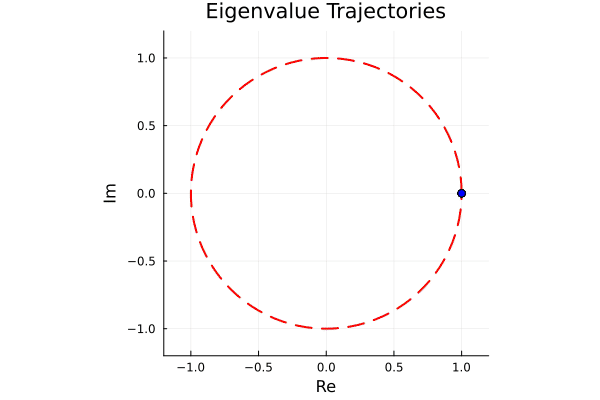

In [156]:
using CUDA, LinearAlgebra, Random, Plots

function near_identity_unitary_gpu(n, epsilon)
    H_gpu = CUDA.randn(ComplexF64, n, n)
    H_gpu = (H_gpu + H_gpu') / 2
    H_cpu = Array(H_gpu)
    dU_cpu = exp(im * (epsilon * H_cpu))
    return CuArray(dU_cpu)
end

function unitary_brownian_motion_with_eigs_gpu(n, steps, epsilon; save_interval=1000)
    println("steps = $steps")
    U_gpu = CuArray(Matrix{ComplexF64}(I, n, n))
    num_saves = div(steps, save_interval) + 1
    det_path = zeros(ComplexF64, num_saves)
    eig_history = Vector{Vector{ComplexF64}}(undef, num_saves)
    U_cpu = Array(U_gpu)
    det_path[1] = det(U_cpu)
    eig_history[1] = sort(eigvals(U_cpu), by=angle)
    save_idx = 2
    for i in 1:steps
        dU_gpu = near_identity_unitary_gpu(n, epsilon)
        U_gpu *= dU_gpu
        if i % save_interval == 0
            U_cpu = Array(U_gpu)
            det_path[save_idx] = det(U_cpu)
            eig_history[save_idx] = sort(eigvals(U_cpu), by=angle)
            save_idx += 1
            if i % (save_interval * 100) == 0
                println("$i steps out of $steps completed.")
                flush(stdout)
            end
        end
    end
    println("Finished simulation.")
    return U_gpu, det_path, eig_history
end

n = 10
steps = 10000
epsilon = 0.1
save_interval = 10

final_U, det_path, eig_history = unitary_brownian_motion_with_eigs_gpu(n, steps, epsilon; save_interval=save_interval)

θ = range(0, 2π, length=100)
anim = @animate for i in 1:length(eig_history)
    p = plot(aspect_ratio=:equal, xlims=(-1.2, 1.2), ylims=(-1.2, 1.2),
             xlabel="Re", ylabel="Im", title="Eigenvalue Trajectories", legend=false)
    plot!(cos.(θ), sin.(θ), ls=:dash, lw=2, color=:red)
    for j in 1:n
        path = [eig_history[k][j] for k in 1:i]
        plot!(real.(path), imag.(path), lw=2)
    end
    scatter!(real.(eig_history[i]), imag.(eig_history[i]), ms=4, color=:blue)
    p
end

gif(anim, "eigenvalue_paths_gpu_fast.gif", fps=15)

By running a simulation of small random steps $U \leftarrow U\,e^{iH}$, we approximate continuous Brownian motion on the unitary group, observing how the angles of the eigenvalues diffuse around the unit circle.

This process is related to Dyson’s Brownian motion, where eigenvalues follow stochastic differential equations that preserve the unitary (or orthogonal, symplectic) nature of the matrix ensemble. Overtime, these random increments drive the eigenvalues toward the equilibrium distribution, which in the unitary case is uniform around the circle.

Some applications:

- Quantum Mechanics: random unitary operators can model chaotic quantum systems in nuclear physics, quantum transport, etc
- Number Theory / Riemann Hypothesis: turns out the zeros of the Riemann zeta function and eigenvalue statistics of random matrices are connected! (Montgomery-Odlyzko Law)




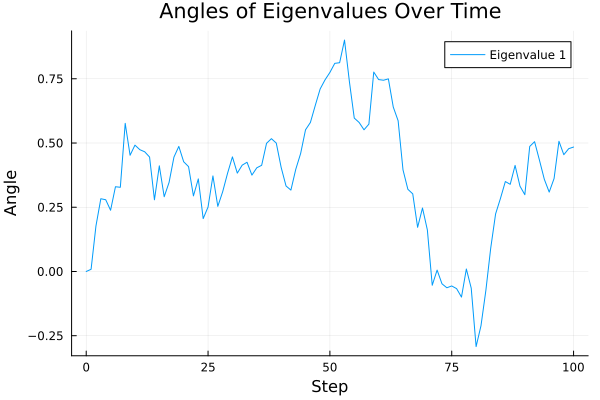

In [155]:
using LinearAlgebra, Random, Plots

function near_identity_unitary(n, epsilon)
    H = randn(n, n) + im * randn(n, n)
    H = (H + H') / 2
    exp(im * (epsilon * H))
end

function unitary_brownian_motion_with_eigs(n, steps, epsilon)
    U = Matrix{ComplexF64}(I, n, n)
    eig_history = Vector{Vector{ComplexF64}}(undef, steps+1)
    eig_history[1] = eigvals(U)
    for i in 1:steps
        U *= near_identity_unitary(n, epsilon)
        eig_history[i+1] = eigvals(U)
    end
    eig_history
end

n = 1
steps = 100
epsilon = 0.1
hist = unitary_brownian_motion_with_eigs(n, steps, epsilon)
angles = [angle.(hist[i]) for i in 1:length(hist)]
A = hcat(angles...)'
p = plot()
for j in 1:n
    plot!(p, 0:steps, A[:, j], label="Eigenvalue $j")
end
xlabel!("Step")
ylabel!("Angle")
title!("Angles of Eigenvalues Over Time")
display(p)

The **Riemann Hypothesis** states that all nontrivial zeros of the Riemann zeta function lie on the line $\text{Re}(s) = \tfrac{1}{2}$. Numerical evidence suggests that, once scaled appropriately, the spacing between these zeros follows the same statistical distribution as eigenvalues from the Gaussian Unitary Ensemble (GUE). This connection is known as the **Montgomery–Odlyzko law**.

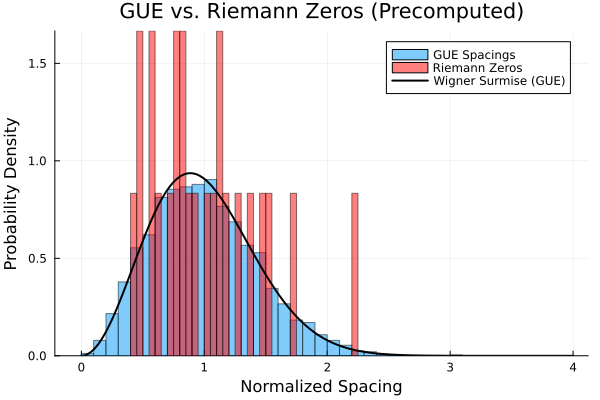

In [164]:
using Random, LinearAlgebra, Statistics, Plots

# Precomputed approximate imaginary parts of the first 25 nontrivial Riemann zeros
# on the line Re(s) = 0.5 (Source: well-known reference tables)
riemann_zeros_approx = [
    14.1347251417346937, 21.0220396387715550, 25.0108575801456888,
    30.4248761258595134, 32.9350615877391890, 37.5861781588256712,
    40.9187190121474930, 43.3270732809149995, 48.0051508811671597,
    49.7738324776723024, 52.9703214777144606, 56.4462476970633945,
    59.3470440026023531, 60.8317785246093745, 65.1125440480816067,
    67.0798105294941737, 69.5464017111739792, 72.0671576744819076,
    75.7046906990839331, 77.1448400688748054, 79.3373750202493673,
    82.9103808540860302, 84.7354929805170501, 87.4252746131252299,
    88.8091112076344659
]

# Generate an n×n GUE matrix (complex Hermitian with certain variance scaling).
function generate_gue(n)
    A = randn(ComplexF64, n, n) / √n
    (A + A') / 2
end

# Compute normalized spacings of a sorted array of real numbers.
function normalized_spacings(vals)
    sorted_vals = sort(vals)
    raw_spacings = diff(sorted_vals)
    raw_spacings ./ mean(raw_spacings)
end

# Wigner surmise for GUE
function wigner_surmise_gue(s)
    (32 / π^2) * s.^2 .* exp.(-4s.^2 / π)
end

# Compare spacing distributions: GUE vs. Riemann zeros
function compare_gue_and_riemann(n, num_matrices)
    # Collect GUE spacings
    all_spacings = Float64[]
    for _ in 1:num_matrices
        H = generate_gue(n)
        eigvals_H = eigvals(H)
        # Keep only "bulk" eigenvalues to reduce finite-size edge effects
        k1 = Int(round(n * 0.2))
        k2 = Int(round(n * 0.8))
        if k1 < 1; k1 = 1; end
        if k2 > n; k2 = n; end
        bulk = eigvals_H[k1:k2]
        append!(all_spacings, normalized_spacings(bulk))
    end
    
    # Get normalized spacings for the precomputed Riemann zeros
    r_spacings = normalized_spacings(riemann_zeros_approx)
    
    # Plot
    srange = range(0, 4, length=200)
    p = histogram(all_spacings, bins=40, normalize=true, alpha=0.5,
        label="GUE Spacings", xlabel="Normalized Spacing",
        ylabel="Probability Density", title="GUE vs. Riemann Zeros (Precomputed)")
    
    histogram!(p, r_spacings, bins=40, normalize=true, alpha=0.5,
        label="Riemann Zeros", color=:red)
    
    plot!(p, srange, wigner_surmise_gue.(srange), color=:black, lw=2,
        label="Wigner Surmise (GUE)")
    
    return p
end

# Example usage:
Random.seed!(123)
n = 80
num_matrices = 50
plot_ = compare_gue_and_riemann(n, num_matrices)
display(plot_)
